In [36]:
#!pip install beautifulsoup4
#!pip install requests
#!pip install tk
#!pip install pillow
#!pip install python-dotenv
#!pip install livelossplot
#!pip install pydot

In [1]:
import requests
import csv
import json
from bs4 import BeautifulSoup
import re
import math
import random
import statistics
import tkinter
import turtle
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from tkinter import messagebox
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv,dotenv_values
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLossesKeras
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

# Construcción del DataSet

## Inicialización y utilidades

In [4]:
load_dotenv()
config = dotenv_values("token.env")
bearer = config["bearer"]

tweets_file = 'tweets.csv'
file = 'dataSet.csv'
GLOBAL_RULES = set()

#Iniciacilización de las reglas globales
if os.path.exists(file):
    with open(file) as file_csv:
        lines = csv.reader(file_csv)
        for row in lines:
            GLOBAL_RULES.add(row[1])

def add_system(file,system):
    with open(file, 'a',newline='') as f_csv:
        writer = csv.writer(f_csv)
        GLOBAL_RULES.add(json.dumps(system['Rules']))
        writer.writerow([system['Start'],str(system['Rules']),system['Angle'],system['Likes']])

## Extracción de tweets y los likes asociados 

In [ ]:
def twitter_API(id):
    url = "https://api.twitter.com/labs/2/tweets/" + id + "?tweet.fields=public_metrics"
    r = requests.get(url,headers={'Authorization':'Bearer ' + bearer})
    return r.json()

In [ ]:
#Extrae Tweets y devuelve el máximo de likes para ponderar los sistemas L 'bien conocidos'
def create_data_set(file):
    #Read IDs
    with open('tweets.txt') as f_txt:
        lines = f_txt.readlines()
        for id in lines:
            response = twitter_API(str(id).strip())
            print(response)
            dict = eval(response['data']["text"][:-24].replace("true","True").replace("false","False"))
            start = dict['start']
            rules = dict['rules']

            if 'a' in dict:
                angle = dict['a']
            else:
                angle = 'unknown'
                
            likes = response['data']["public_metrics"]["like_count"]
            
            global_likes.append(int(likes))
            
            system = {}
            system['Start'] = start
            system['Rules'] = rules
            system['Angle'] = angle
            system['Likes'] = likes
            add_system(file,system)

In [ ]:
create_data_set(tweets_file)

## Adaptando Likes al rango 0-50

In [ ]:
header = ["Axiom","Rules","Angle","Likes"]
tweets_df = pd.read_csv(tweets_file,header=None,names=header,na_filter = False)
tweets_df.head(10)

In [ ]:

likes = tweets_df['Likes'].tolist()
m = tweets_df.mean()["Likes"]
sd = tweets_df.std()["Likes"]



band_1 = m+sd
band_2 = band_1 + sd
band_3 = band_2 + sd
print("Media: " + str(m))
print("Desviación Estándar: " + str(sd))
print("Primera banda (34%): " + str(band_1))
print("Segunda banda (14%): " + str(band_2))
print("Tercera banda (2%): " + str(band_3))

plt.figure(0)
plt.hist(likes,edgecolor='k',density=True,bins=20,stacked=False)
plt.axvline(m,color='k')
plt.axvline(band_1,color='k', linestyle='dashed')
plt.axvline(band_2,color='k', linestyle='dashed')
plt.axvline(band_3,color='k', linestyle='dashed')

plt.show()
plt.close()


In [ ]:
likes_updated = []
for i in tweets_df.index.values:
    like = tweets_df.iloc[i]["Likes"]
    if like >= band_3:
        like = 50
    likes_updated.append(like/50)
    
tweets_df["Likes"] = likes_updated
tweets_df.head(10)

tweets_df.to_csv(file,index=False,header=False)

## Extracción de Sistemas-L con reglas conocidas

In [ ]:
#Entrada: F > FXF | Salida: {'F':'FXF'}
def extract_rules(rules):
    rules_dict = dict()
    for rule in rules:
        if re.match("\w\s>",rule):
            fields = rule.split(">")
            rules_dict[fields[0].strip()] = fields[1].strip().replace("<","").replace(">","").replace("?","").replace("{","").replace("}","").replace("|","")
        else:
            fields = rule.split("->")
            rules_dict[fields[0].strip()] = fields[1].strip().replace("<","").replace(">","").replace("?","").replace("{","").replace("}","").replace("|","")
    return rules_dict

def extract_system(contents):
    rules = []
    start = ""
    angle = ""
    for content in contents:
        content = str(content).strip()
        if content.startswith('Axiom'):
            start = content.split(":")[1].strip().replace("(","").replace(")","")
        if content.startswith('axiom'):
            start = content.split("=")[1].strip().replace("(","").replace(")","")
        if content.startswith('Rule: '):
            rule = content.split(":")[1].strip()
            rules.append(rule)
        if re.match('\w\s>',content):
            rules.append(content.strip())
        if re.match('\w\s->',content):
            rules.append(content.strip())
        if content.startswith('Angle'):
            angle = content.split(":")[1].strip().replace('°','')
            if re.match('π/\d',angle):
                pi=math.pi
                angle = angle.replace('π','pi')
                angle = int(math.degrees(eval(angle)))
        if content.startswith('angle'):
            angle = content.split("=")[1].strip().replace('°','')
    return (start,rules,angle)

In [ ]:
def find_all_p(s):
    result = []
    p_s = s.find_all("p")
    for p in p_s:
        if "axiom =" in p.text:
            result.append(",".join(p.stripped_strings).split(","))
    return result

In [ ]:
def wellKnown_systems_scraping(file,url,likes):
    
    response = requests.get(url)
    s = BeautifulSoup(response.text,'lxml')

    table = s.find("table",attrs={"border":"1"})
    if table:
        trs = table.find_all("tr")
        for tr in trs:
            contents = tr.find_all("td")[1].contents

            start,rules,angle = extract_system(contents)

            rules_dict = extract_rules(rules)
            system = dict()
            system['Start'] = start
            system['Rules'] = rules_dict
            system['Angle'] = angle
            system['Likes'] = likes
            
            add_system(file,system)
    else:
        table = s.find_all("td",attrs={"valign":"top"})
        for t in table:
            if t.text.strip().startswith('axiom'):
                contents = t.contents
                
                start,rules,angle = extract_system(contents)
                
                rules_dict = extract_rules(rules)
                system = dict()
                system['Start'] = start
                system['Rules'] = rules_dict
                system['Angle'] = angle
                system['Likes'] = likes
                
                add_system(file,system)
        
        p_systems = find_all_p(s)
        for contents in p_systems:
            start,rules,angle = extract_system(contents)
            rules_dict = extract_rules(rules)
            system = dict()
            system['Start'] = start
            system['Rules'] = rules_dict
            system['Angle'] = angle
            system['Likes'] = likes
            
            add_system(file,system)


## Creación del data set con los tweets y los sistemas con reglas conocidas


In [ ]:
likes = create_data_set(tweets_file)

urls = ["https://fedimser.github.io/l-systems.html","http://paulbourke.net/fractals/lsys/"]
for url in urls:
    wellKnown_systems_scraping(file,url,1)
    

## Generación de sistemas L

In [66]:
def generate_random_string(min,max,charSet):
    length = random.randint(min,max)
    string = ''
    for i in range(length):
        char = charSet[random.randint(0,len(charSet) - 1)]
        if char == ']':
            if len(string) == 0:
                index = 0
                string = string[0:index] + '[' + string[index:]
            else:
                index = random.randint(0,len(string) - 1)
                string = string[0:index] + '[' + string[index:]
        string += char
    return string
    
def generate():
    l_system = []
    charSet = ['F']
    alphabet = list('ABCDEGHIJKLMNOPQRSTUVWXYZ')
    controlCharSet = ['F', '+', '-', ']']
    angles = [36, 45, 60, 90, random.randint(0,359), random.randint(0,359)]
    iters = [4, 5, 6]
    extraSymbols = random.randint(1,4)
    
    for i in range(extraSymbols):
        index = random.randint(0,len(alphabet) - 1)
        charSet.append(alphabet[index])
        alphabet.pop(index)
    
    start = generate_random_string(1,5,charSet)
    
    rules = {}
    for char in charSet:
        rule = generate_random_string(0,10,charSet + controlCharSet)
        rules[char] = rule
        
    angle = angles[random.randint(0,len(angles) - 1)]
    iter = iters[random.randint(0,len(iters) - 1)]
    
    return start,rules,angle,iter
    
        

In [67]:
# @pvigier 

def to_radian(angle):
    return angle * np.pi / 180

def rotate(vector, angle):
    theta = to_radian(angle)
    matrix = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    return np.dot(matrix, vector)

def rotate_x(vector, angle):
    theta = to_radian(angle)
    matrix = [[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]]
    return np.dot(matrix, vector)

def rotate_y(vector, angle):
    theta = to_radian(angle)
    matrix = [[np.cos(theta), 0, -np.sin(theta)], [0, 1, 0], [np.sin(theta), 0, np.cos(theta)]]
    return np.dot(matrix, vector)

def rotate_z(vector, angle):
    theta = to_radian(angle)
    matrix = [[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]]
    return np.dot(matrix, vector)

def plot2d(string, alpha, delta=1, init_direction=np.array([1., 0]), colors={}):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.gca().set_aspect('equal', adjustable='box')
    pos = np.zeros(2, dtype=np.float64)
    direction = init_direction
    color = 'c'
    saved_states = []
    for x in string:
        if x in list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
            new_pos = pos + direction
            ax.plot([pos[0], new_pos[0]], [pos[1], new_pos[1]], c=color)
            pos = new_pos
        elif x == '+':
            direction = rotate(direction, alpha)
        elif x == '-':
            direction = rotate(direction, -alpha)
        elif x == '*':
            direction *= delta
        elif x == '/':
            direction /= delta
        elif x == '|':
            direction = rotate(direction, 180)
        elif x == '[':
            saved_states.append((pos, direction))
        elif x == ']':
            pos, direction = saved_states.pop()
        elif x in colors:
            color = colors[x]
    return fig

In [68]:
system = {}
prev_fig = None

# @ambron60
def derivation(axiom, steps, rules):
    derived = [axiom]  # seed
    for _ in range(steps):
        next_seq = derived[-1]
        next_axiom = [rule(char,rules) for char in next_seq]
        derived.append(''.join(next_axiom)) 
    return derived

# @ambron60
def rule(sequence, rules):
    if sequence in rules:
        return rules[sequence]
    return sequence

def generator_GUI(): 

    def generate_drawing():
        global prev_fig,system
        start,rules,angle,iter = generate()
        system['Start'] = start
        system['Rules'] = rules
        system['Angle'] = angle
        print(start,rules,angle)
        model = derivation(start,iter,rules) 
        print(model)
        
        if not prev_fig == None:
            plt.clf()
            plt.close("all")
        
        fig = plot2d(model[-1],angle,colors={'blue':'blue'})
        prev_fig = fig
        
        canvas = FigureCanvasTkAgg(fig,master=window)
        canvas.get_tk_widget().grid(row=1, column=0, ipadx=40, ipady=20)


    def process():
        global system
        text = box.get()
        if text == "" or not re.search("^\d{0,2}$",text) or int(text) > 50:
            messagebox.showerror(title="Incorrecto", message="Introduzca un número correcto")
            return
        system['Likes'] = int(text)/50
        add_system('dataSet.csv',system)
        generate_drawing()

    
    window = tkinter.Tk()
    window.resizable(False, False)
    window.title('Generador Sistemas L')

    
    frame = tkinter.LabelFrame(window, text='LSystems', bg='#f0f0f0', font=(20))

    frame.grid(row=0, column=0, padx=100, pady=100)

    
    generate_drawing()
    
    label = tkinter.Label(frame,text='Calidad(0-50)')
    label.grid(row=0,column=0)

    box = tkinter.Entry(frame)
    box.grid(row=0,column=1)

    process_button = tkinter.Button(frame,text='Guardar',command=process)
    process_button.grid(row=1,column=1,sticky = "we",pady=5)

    window.mainloop()



JVV {'F': 'FVF-', 'V': 'F-', 'J': '-FFF', 'Q': 'FJ'} 45
['JVV', '-FFFF-F-', '-FVF-FVF-FVF-FVF--FVF--', '-FVF-F-FVF--FVF-F-FVF--FVF-F-FVF--FVF-F-FVF---FVF-F-FVF---', '-FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF----FVF-F-FVF--FVF--FVF-F-FVF----', '-FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF----FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF----FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF----FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF-----FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF-----', '-FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF----FVF-F-FVF--FVF--FVF-F-FVF----FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF-----FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF----FVF-F-FVF--FVF--FVF-F-FVF----FVF-F-FVF--FVF--FVF-F-FVF---FVF-F-FVF---FVF-F-FVF--FVF--FVF-F-FVF---

KeyboardInterrupt: 

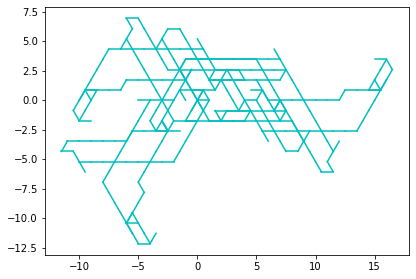

In [73]:
generator_GUI()

# Construccion de Modelos

## Funciones necesarias

In [2]:
file = 'dataSet.csv'
def derivation(axiom, steps, rules):
    derived = [axiom]  # seed
    for _ in range(steps):
        next_seq = derived[-1]
        next_axiom = [rule(char,rules) for char in next_seq]
        derived.append(''.join(next_axiom)) 
    return derived

# @ambron60
def rule(sequence, rules):
    if sequence in rules:
        return rules[sequence]
    return sequence

## Preparación de datos

In [3]:
def string2sequence(strings,seq_length):
    
    sequences = []
    vocab = set()


    for element in strings:
        vocab.update(list(element))

    
    index = {char:i+1 for i,char in enumerate(vocab)}

    for element in strings:
        sequence = []
        for char in element:
            sequence.append(index[char])
        
        sequences.append(sequence)

    padded = pad_sequences(sequences,maxlen=seq_length,padding='post')
    
     
    print("==================")
    print("Tamaño del vocabulario: " + str(len(vocab)))
    print("Índice: ") 
    print(index)
    print("Tamaño máximo de las secuencias: " + str(seq_length))
    
    return padded,len(vocab)

In [4]:
header = ["Axiom","Rules","Angle","Likes"]
df = pd.read_csv(file,header=None,names=header,na_filter = False)
df["Sistema"] = df["Axiom"] + df["Rules"] + df["Angle"]
df.head(10)

,Axiom,Rules,Angle,Likes,Sistema
0,XYXF,"{'F': 'F++FX+', 'X': '-F+[F]FAFA', 'A': '+YFEF...",45,0.10,"XYXF{'F': 'F++FX+', 'X': '-F+[F]FAFA', 'A': '+..."
1,FSF,"{'F': 'SCF+B', 'M': '+SCC', 'C': '[]FC', 'S': ...",188,0.06,"FSF{'F': 'SCF+B', 'M': '+SCC', 'C': '[]FC', 'S..."
2,NFCH,"{'F': '[]YHFHFF-', 'N': 'CHC', 'H': 'ECFFNE', ...",36,0.14,"NFCH{'F': '[]YHFHFF-', 'N': 'CHC', 'H': 'ECFFN..."
3,F,"{'F': '[FF-FF--]F', 'L': '[+]'}",60,0.18,"F{'F': '[FF-FF--]F', 'L': '[+]'}60"
4,FF,"{'F': '-WW', 'W': 'FWW'}",238,1.00,"FF{'F': '-WW', 'W': 'FWW'}238"
5,A,"{'F': '[[]][A]+-FA', 'V': '-AAFF+V', 'A': 'F[F...",263,0.00,"A{'F': '[[]][A]+-FA', 'V': '-AAFF+V', 'A': 'F[..."
6,LJFJ,"{'F': '-JF', 'J': 'FL-+F'}",36,0.02,"LJFJ{'F': '-JF', 'J': 'FL-+F'}36"
7,F,"{'F': 'L-F+', 'L': '-FU', 'U': '-FF'}",36,0.00,"F{'F': 'L-F+', 'L': '-FU', 'U': '-FF'}36"
8,IX,"{'F': 'F', 'J': 'LF+X', 'G': 'G[FLFJ]', 'I': '...",36,0.04,"IX{'F': 'F', 'J': 'LF+X', 'G': 'G[FLFJ]', 'I':..."
9,SSDS,"{'F': 'SFF', 'S': 'SFDF+', 'U': '+FF'}",36,0.02,"SSDS{'F': 'SFF', 'S': 'SFDF+', 'U': '+FF'}36"


In [5]:
result = []
for i in df.index.values:
    result.append(derivation(df.iloc[i]["Axiom"],4,eval(df.iloc[i]["Rules"]))[-1])
    
df["Desarrollado"] = result
df.head(10)

,Axiom,Rules,Angle,Likes,Sistema,Desarrollado
0,XYXF,"{'F': 'F++FX+', 'X': '-F+[F]FAFA', 'A': '+YFEF...",45,0.10,"XYXF{'F': 'F++FX+', 'X': '-F+[F]FAFA', 'A': '+...",-F++FX+++F++FX+-F+[F]FAFA+++F++FX+++F++FX+-F+[...
1,FSF,"{'F': 'SCF+B', 'M': '+SCC', 'C': '[]FC', 'S': ...",188,0.06,"FSF{'F': 'SCF+B', 'M': '+SCC', 'C': '[]FC', 'S...",[]+[][]+[]FCSCF+B+SB+M++FBF[]SCF+B[]FC[]+[]SCF...
2,NFCH,"{'F': '[]YHFHFF-', 'N': 'CHC', 'H': 'ECFFNE', ...",36,0.14,"NFCH{'F': '[]YHFHFF-', 'N': 'CHC', 'H': 'ECFFN...",CEC[]N[E]ECFFNE[]YHFHFF-ECFFNE[]YHFHFF-[]YHFHF...
3,F,"{'F': '[FF-FF--]F', 'L': '[+]'}",60,0.18,"F{'F': '[FF-FF--]F', 'L': '[+]'}60",[[[[FF-FF--]F[FF-FF--]F-[FF-FF--]F[FF-FF--]F--...
4,FF,"{'F': '-WW', 'W': 'FWW'}",238,1.00,"FF{'F': '-WW', 'W': 'FWW'}238",--FWWFWW-WWFWWFWW-WWFWWFWW-FWWFWW-WWFWWFWW-WWF...
5,A,"{'F': '[[]][A]+-FA', 'V': '-AAFF+V', 'A': 'F[F...",263,0.00,"A{'F': '[[]][A]+-FA', 'V': '-AAFF+V', 'A': 'F[...",[[]][[[]][A]+-FA[[[]][A]+-FA]+[[]][A]+-FA[[]][...
6,LJFJ,"{'F': '-JF', 'J': 'FL-+F'}",36,0.02,"LJFJ{'F': '-JF', 'J': 'FL-+F'}36",L--JFL-+-JF-FL-+F-JFL-+--JFL-+-JF-FL-+F-JF--FL...
7,F,"{'F': 'L-F+', 'L': '-FU', 'U': '-FF'}",36,0.00,"F{'F': 'L-F+', 'L': '-FU', 'U': '-FF'}36",--FU-L-F++-L-F+L-F+--L-F+-FF--FU-L-F++++
8,IX,"{'F': 'F', 'J': 'LF+X', 'G': 'G[FLFJ]', 'I': '...",36,0.04,"IX{'F': 'F', 'J': 'LF+X', 'G': 'G[FLFJ]', 'I':...",[G[FLFJ][FFIIFFLF+X][FF[G][G]FFFIIFF+[FJ]F]][F...
9,SSDS,"{'F': 'SFF', 'S': 'SFDF+', 'U': '+FF'}",36,0.02,"SSDS{'F': 'SFF', 'S': 'SFDF+', 'U': '+FF'}36",SFDF+SFFDSFF+SFDF+SFFSFFDSFDF+SFFSFF+SFDF+SFFD...


# Modelo 1: Sistema desarrollado en 4 iteraciones

## Creación de Secuencias

### Visualizando las longitudes de las secuencias

Media: 439.0
Desviación Estándar: 31340.588314555884
Primera banda: 31779.588314555884
Segunda banda: 63120.17662911177
Tercera banda: 94460.76494366766
Longitud máxima: 5000


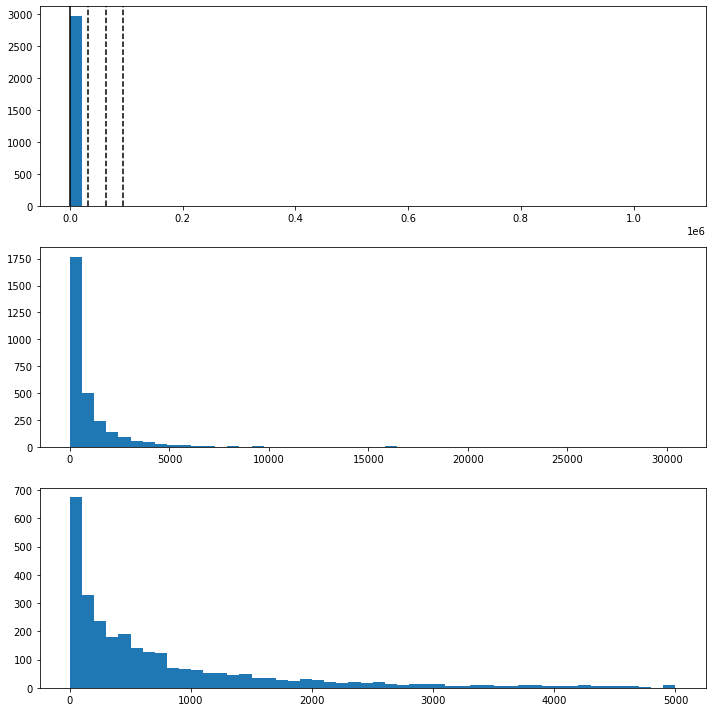

In [15]:
lengths = []
for model in df.Desarrollado.tolist():
    lengths.append(len(model))
m = statistics.median(lengths)
sd = np.std(lengths)

band_1 = m + sd
band_2 = band_1 + sd
band_3 = band_2 + sd

s = [ 1 for l in lengths if  30000 <= l <=40000]



print("Media: " + str(m))
print("Desviación Estándar: " + str(sd))
print("Primera banda: " + str(band_1))
print("Segunda banda: " + str(band_2))
print("Tercera banda: " + str(band_3))


fig, ax = plt.subplots(3,figsize=(10,10))
ax[0].hist(lengths,bins=50)
ax[0].axvline(m,color='k')
ax[0].axvline(band_1,color='k', linestyle='dashed')
ax[0].axvline(band_2,color='k', linestyle='dashed')
ax[0].axvline(band_3,color='k', linestyle='dashed')

split_1 = [ l for l in lengths if l <= band_1]
ax[1].hist(split_1,bins=50)


split_2 = [ l for l in split_1 if l <= 5000]
ax[2].hist(split_2,bins=50)

max_length = 5000
print("Longitud máxima: " + str(max_length))
plt.tight_layout()

In [16]:
model_limit = []
for model in df.Desarrollado.tolist():
    model_limit.append(model[0:max_length])
    

df["Desarrollado Truncado"] = model_limit
df.head()

,Axiom,Rules,Angle,Likes,Desarrollado,Sistema,Desarrollado Truncado
0,XYXF,"{F: F++FX+, X: -F+[F]FAFA, A: +YFEF-E, E: YFEA...",45,0.10,-F++FX+++F++FX+-F+[F]FAFA+++F++FX+++F++FX+-F+[...,"XYXF{F: F++FX+, X: -F+[F]FAFA, A: +YFEF-E, E: ...",-F++FX+++F++FX+-F+[F]FAFA+++F++FX+++F++FX+-F+[...
1,FSF,"{F: SCF+B, M: +SCC, C: []FC, S: []+, B: SB+M++...",188,0.06,[]+[][]+[]FCSCF+B+SB+M++FBF[]SCF+B[]FC[]+[]SCF...,"FSF{F: SCF+B, M: +SCC, C: []FC, S: []+, B: SB+...",[]+[][]+[]FCSCF+B+SB+M++FBF[]SCF+B[]FC[]+[]SCF...
2,NFCH,"{F: []YHFHFF-, N: CHC, H: ECFFNE, Y: N[E]}",36,0.14,CEC[]N[E]ECFFNE[]YHFHFF-ECFFNE[]YHFHFF-[]YHFHF...,"NFCH{F: []YHFHFF-, N: CHC, H: ECFFNE, Y: N[E]}36",CEC[]N[E]ECFFNE[]YHFHFF-ECFFNE[]YHFHFF-[]YHFHF...
3,F,"{F: [FF-FF--]F, L: [+]}",60,0.18,[[[[FF-FF--]F[FF-FF--]F-[FF-FF--]F[FF-FF--]F--...,"F{F: [FF-FF--]F, L: [+]}60",[[[[FF-FF--]F[FF-FF--]F-[FF-FF--]F[FF-FF--]F--...
4,FF,"{F: -WW, W: FWW}",238,1.00,--FWWFWW-WWFWWFWW-WWFWWFWW-FWWFWW-WWFWWFWW-WWF...,"FF{F: -WW, W: FWW}238",--FWWFWW-WWFWWFWW-WWFWWFWW-FWWFWW-WWFWWFWW-WWF...


In [17]:
padded,vocab = string2sequence(model_limit, max_length)


Tamaño del vocabulario: 48
Índice: 
{'-': 1, 'R': 2, 'T': 3, 'N': 4, 'y': 5, 'L': 6, 'j': 7, 'G': 8, 'K': 9, 'f': 10, 'I': 11, 'U': 12, 'V': 13, 'n': 14, 'u': 15, 'P': 16, 'q': 17, 'm': 18, 't': 19, '+': 20, 'X': 21, 'o': 22, 'h': 23, 'Y': 24, 'A': 25, '[': 26, 'S': 27, 'W': 28, 'k': 29, ']': 30, 'B': 31, 'H': 32, 's': 33, 'E': 34, 'O': 35, 'w': 36, 'e': 37, 'M': 38, 'C': 39, 'Z': 40, 'Q': 41, 'v': 42, 'p': 43, 'a': 44, 'F': 45, 'D': 46, 'b': 47, 'J': 48}
Tamaño máximo de las secuencias: 5000


In [18]:
y = np.array(df.Likes.to_list())
X_train, X_test,Y_train,Y_test = train_test_split(padded,y,test_size=0.20, random_state=42)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((2387, 5000), (597, 5000), (2387,), (597,))

## Modelo 1 - CNN 

In [534]:
vocab_size = vocab+1
embedding_dimension = 32

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, embedding_dimension, input_length=max_length)(input_layer)
conv_layer_1 = Conv1D(filters=32, kernel_size=3, activation=tf.keras.layers.LeakyReLU())(embedding_layer)
pool_1 = MaxPooling1D(pool_size=4)(conv_layer_1)
conv_layer_2 = Conv1D(filters=32, kernel_size=3, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.01))(pool_1)
pool_2 = MaxPooling1D(pool_size=4)(conv_layer_2)
flatten = Flatten()(pool_2)
dense_2 = Dense(10, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer=l2(l2=0.01))(flatten)
dropout = Dropout(0.5)(dense_2)
output_layer = Dense(1, activation='sigmoid')(dropout)

model_1_cnn = Model(inputs=input_layer,outputs=output_layer)
model_1_cnn.summary()

Model: "model_219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_390 (InputLayer)       [(None, 5000)]            0         
_________________________________________________________________
embedding_389 (Embedding)    (None, 5000, 32)          1568      
_________________________________________________________________
conv1d_1076 (Conv1D)         (None, 4998, 32)          3104      
_________________________________________________________________
max_pooling1d_629 (MaxPoolin (None, 1249, 32)          0         
_________________________________________________________________
conv1d_1077 (Conv1D)         (None, 1247, 32)          3104      
_________________________________________________________________
max_pooling1d_630 (MaxPoolin (None, 311, 32)           0         
_________________________________________________________________
flatten_370 (Flatten)        (None, 9952)              0 

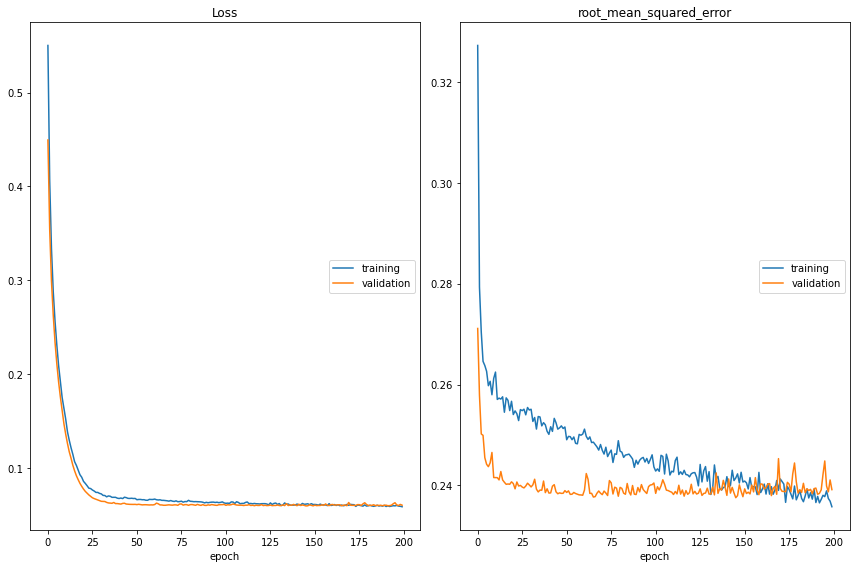

Loss
	training         	 (min:    0.059, max:    0.550, cur:    0.059)
	validation       	 (min:    0.059, max:    0.450, cur:    0.060)
root_mean_squared_error
	training         	 (min:    0.236, max:    0.327, cur:    0.236)
	validation       	 (min:    0.238, max:    0.271, cur:    0.239)


In [535]:
model_1_cnn.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_1_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=32, verbose=1,callbacks=[PlotLossesKeras()])
model_1_cnn.save('model_1.h5')

## Modelo 2 - MultiChannel

In [666]:
vocab_size = vocab+1
embedding_dimension = 32
# channel 1
inputs1 = Input(shape=(max_length,))
embedding1 = Embedding(vocab_size,embedding_dimension,input_length=max_length)(inputs1)
conv1 = Conv1D(filters=32, kernel_size=4, padding='same', activation='relu')(embedding1)
pool_1 = MaxPooling1D(pool_size=4)(conv1)
conv2 = Conv1D(filters=32, kernel_size=4, padding='same', activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.001))(pool_1)
pool_2 = MaxPooling1D(pool_size=4)(conv2)
flat1 = Flatten()(pool_2)

# channel 2
inputs2 = Input(shape=(max_length,))
embedding2 = Embedding(vocab_size, embedding_dimension, input_length=max_length)(inputs2)
conv3 = Conv1D(filters=32, kernel_size=6, padding='same', activation=tf.keras.layers.LeakyReLU())(embedding2)
pool_3 = MaxPooling1D(pool_size=4)(conv3)
conv4 = Conv1D(filters=32, kernel_size=6, padding='same', activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.001))(pool_3)
pool_4 = MaxPooling1D(pool_size=4)(conv4)
flat2 = Flatten()(pool_4)

# channel 3
inputs3 = Input(shape=(max_length,))
embedding3 = Embedding(vocab_size, embedding_dimension, input_length=max_length)(inputs3)
conv5 = Conv1D(filters=32, kernel_size=8, padding='same', activation=tf.keras.layers.LeakyReLU())(embedding3)
pool_5 = MaxPooling1D(pool_size=4)(conv5)
conv6 = Conv1D(filters=32, kernel_size=8, padding='same', activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.001))(pool_5)
pool_6 = MaxPooling1D(pool_size=4)(conv6)
flat3 = Flatten()(pool_6)

# merge
merged = concatenate([flat1, flat2, flat3])

dense1 = Dense(32, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.001))(merged)
drop4 = Dropout(0.5)(dense1)
outputs = Dense(1, activation='sigmoid')(drop4)

model_2_multi_channel = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
model_2_multi_channel.summary()

Model: "model_269"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_492 (InputLayer)          [(None, 5000)]       0                                            
__________________________________________________________________________________________________
input_493 (InputLayer)          [(None, 5000)]       0                                            
__________________________________________________________________________________________________
input_494 (InputLayer)          [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding_491 (Embedding)       (None, 5000, 32)     1568        input_492[0][0]                  
__________________________________________________________________________________________

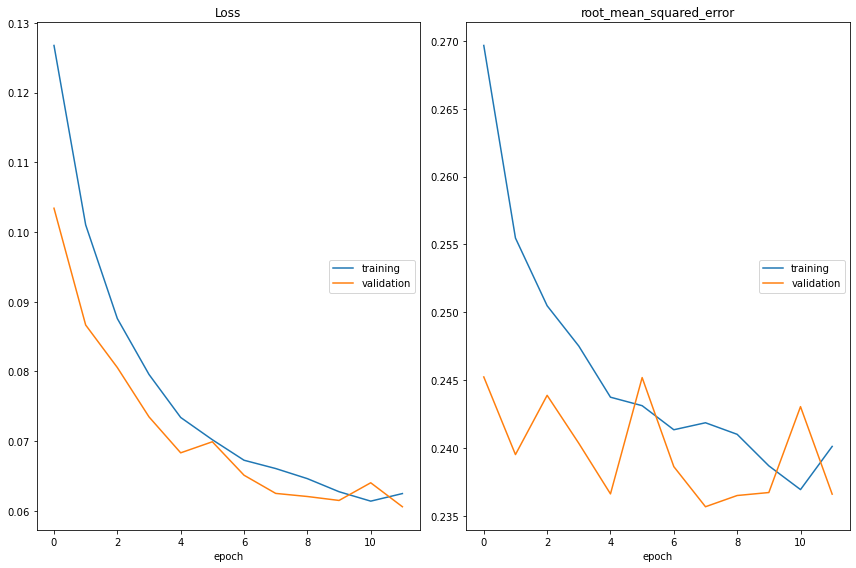

Loss
	training         	 (min:    0.061, max:    0.127, cur:    0.062)
	validation       	 (min:    0.061, max:    0.103, cur:    0.061)
root_mean_squared_error
	training         	 (min:    0.237, max:    0.270, cur:    0.240)
	validation       	 (min:    0.236, max:    0.245, cur:    0.237)
Epoch 13/20
48/75 [==================>...........] - ETA: 13s - loss: 0.0593 - root_mean_squared_error: 0.2340

KeyboardInterrupt: 

In [667]:
model_2_multi_channel.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_2_multi_channel.fit([X_train,X_train,X_train], Y_train, validation_data=([X_test,X_test,X_test], Y_test), epochs=20, batch_size=32, verbose=1,callbacks=[PlotLossesKeras()])
model_2_multi_channel.save('model_2.h5')

## Modelo 3 - Autoencoder y RNN

### Autoencoder para reducir dimensionalidad

In [ ]:
one_hot_encoded = []   
x_rnn = []
for sequence in padded:
    sub_sequence = []
    for split in range(0,len(sequence),n):
        one_hot = to_categorical(sequence[split:split+n],num_classes=vocab+1)
        one_hot_encoded.append(one_hot)
        sub_sequence.append(one_hot)
    x_rnn.append(sub_sequence)
    
x_ae = np.asarray(one_hot_encoded)
x_rnn = np.asarray(x_rnn)
x_ae.shape

In [232]:
X_train, X_test = train_test_split(x_ae,test_size=0.30, random_state=42)

X_train.shape,X_test.shape


((104440, 100, 49), (44760, 100, 49))

In [237]:
encoder_input = Input(shape=(n, vocab+1),name="encoder_input") 
 

x = Conv1D(32,3,padding='same',activation=tf.keras.layers.LeakyReLU(),name="encoder_conv_0")(encoder_input)
x = MaxPooling1D(name="encoder_sampling_0")(x)
x = Conv1D(32,3,padding='same',activation=tf.keras.layers.LeakyReLU(),name="encoder_conv_1")(x)
x = MaxPooling1D(name="encoder_sampling_1")(x)
x = Conv1D(32,3,padding='same',activation=tf.keras.layers.LeakyReLU(),name="encoder_conv_2",kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = MaxPooling1D(name="encoder_sampling_2",pool_size=5)(x)

shape_before_flattening = x.get_shape()[1:]

x = Flatten()(x)


latent_space = Dense(50,name="latent_space")(x)

x = Dense(np.prod(shape_before_flattening),name="decoder_input")(latent_space)
x = Reshape(shape_before_flattening,name="decoder_reshape")(x)


x = Conv1D(32,3,padding='same',activation=tf.keras.layers.LeakyReLU(),name="decoder_conv_1")(x)
x = UpSampling1D(name="decoder_upSampling_1",size=5)(x)
x = Conv1D(32,3,padding='same',activation=tf.keras.layers.LeakyReLU(),name="decoder_conv_2")(x)
x = UpSampling1D(name="decoder_upSampling_2")(x)
x = Conv1D(32,3,padding='same',activation=tf.keras.layers.LeakyReLU(),name="decoder_conv_3")(x)
x = UpSampling1D(name="decoder_upSampling_3")(x)

decoder_output = Conv1D(vocab+1,3,padding='same',activation=tf.keras.layers.LeakyReLU(),name="decoder_output")(x)


autoencoder = Model(encoder_input,decoder_output,name="Autoencoder")
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100, 49)]         0         
_________________________________________________________________
encoder_conv_0 (Conv1D)      (None, 100, 32)           4736      
_________________________________________________________________
encoder_sampling_0 (MaxPooli (None, 50, 32)            0         
_________________________________________________________________
encoder_conv_1 (Conv1D)      (None, 50, 32)            3104      
_________________________________________________________________
encoder_sampling_1 (MaxPooli (None, 25, 32)            0         
_________________________________________________________________
encoder_conv_2 (Conv1D)      (None, 25, 32)            3104      
_________________________________________________________________
encoder_sampling_2 (MaxPooli (None, 5, 32)             

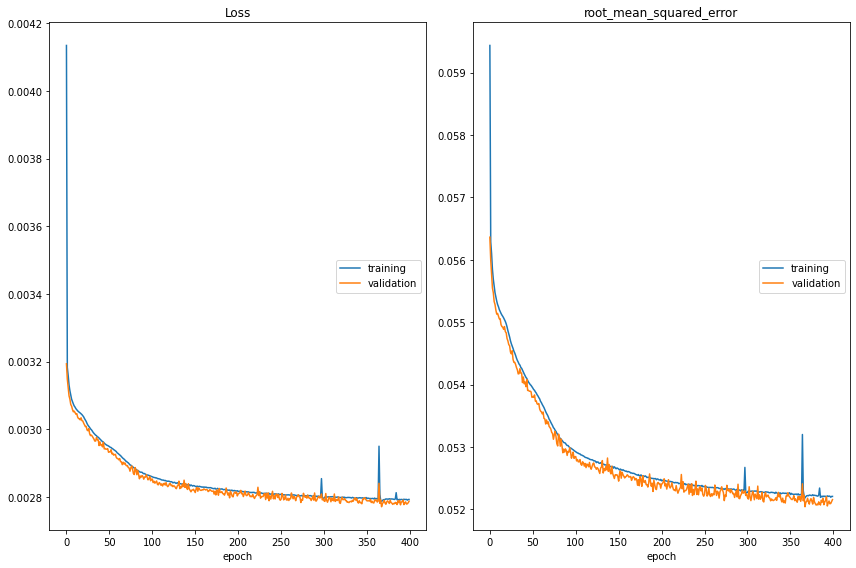

Loss
	training         	 (min:    0.003, max:    0.004, cur:    0.003)
	validation       	 (min:    0.003, max:    0.003, cur:    0.003)
root_mean_squared_error
	training         	 (min:    0.052, max:    0.059, cur:    0.052)
	validation       	 (min:    0.052, max:    0.056, cur:    0.052)


In [238]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="mean_squared_error",metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_ae = autoencoder.fit(x=X_train,y=X_train,validation_data=(X_test,X_test),batch_size=128,shuffle=True,epochs=400,callbacks=[PlotLossesKeras()])

autoencoder.save('autoencoder_v2.h5')

In [239]:
autoencoder = load_model('autoencoder.h5')
encoder = Model(autoencoder.input,autoencoder.get_layer("latent_space").output)
encoder.summary()


Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100, 49)]         0         
_________________________________________________________________
encoder_conv_0 (Conv1D)      (None, 100, 32)           4736      
_________________________________________________________________
encoder_sampling_0 (MaxPooli (None, 50, 32)            0         
_________________________________________________________________
encoder_conv_1 (Conv1D)      (None, 50, 32)            3104      
_________________________________________________________________
encoder_sampling_1 (MaxPooli (None, 25, 32)            0         
_________________________________________________________________
encoder_conv_2 (Conv1D)      (None, 25, 32)            3104      
_________________________________________________________________
encoder_sampling_2 (MaxPooli (None, 5, 32)             0  

## Guardar los datos generados por el autoencoder  en un txt 

In [240]:
x = []
y = np.array(df.Likes.to_list())
for sample in x_rnn:
    coded = encoder.predict(sample)
    x.append(coded)
x = np.asarray(x)

In [241]:
np.set_printoptions(threshold=np.inf)
x_reshaped = x.reshape(x.shape[0], -1)
np.savetxt("autoencoder_outputs.txt", x_reshaped)

## Cargar los datos generados por el autoencoder desde un txt

In [54]:
loaded_arr = np.loadtxt("autoencoder_outputs.txt")
x_read = loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] // 50, 50)

In [55]:
x_read.shape

(2984, 50, 50)

In [56]:
x = np.asarray(x_read)
y = np.array(df.Likes.to_list())
X_train, X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.20, random_state=42)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape


((2387, 50, 50), (597, 50, 50), (2387,), (597,))

## RNN

In [57]:
input_layer = Input(shape=(50,50)) 
lstm_layer = LSTM(50)(input_layer)
dense_layer = Dense(50,activation=tf.keras.layers.LeakyReLU())(lstm_layer)
dropout = Dropout(0.5)(dense_layer)
dense_layer_2 = Dense(32,activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001),activity_regularizer=l2(0.001))(dropout)
output = Dense(1,activation='sigmoid')(dense_layer_2)

model_3_rnn = Model(input_layer,output)
model_3_rnn.summary()


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 50, 50)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_29 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_38 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 24,415
Trainable params: 24,415
Non-trainable params: 0
______________________________________________________

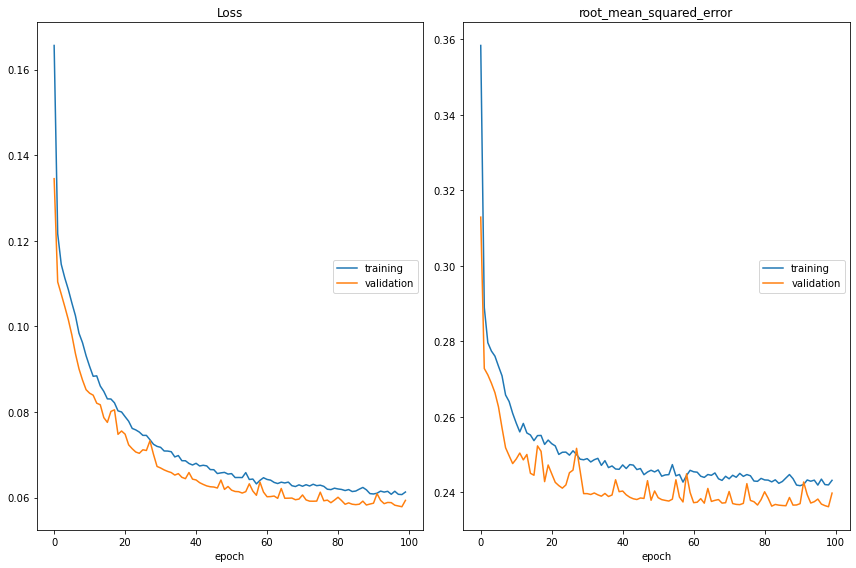

Loss
	training         	 (min:    0.061, max:    0.166, cur:    0.061)
	validation       	 (min:    0.058, max:    0.134, cur:    0.059)
root_mean_squared_error
	training         	 (min:    0.242, max:    0.358, cur:    0.243)
	validation       	 (min:    0.236, max:    0.313, cur:    0.240)


In [58]:
model_3_rnn.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_3_rnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, verbose=1,callbacks=[PlotLossesKeras()])
model_3_rnn.save('model_3.h5')

# Entrada: Definición del sistema-L

Media: 57.0
Desviación Estándar: 21.894095554563123
Primera banda (34%): 78.89409555456312
Segunda banda (14%): 100.78819110912625
Tercera banda (2%): 122.68228666368937
Longitud máxima: 122


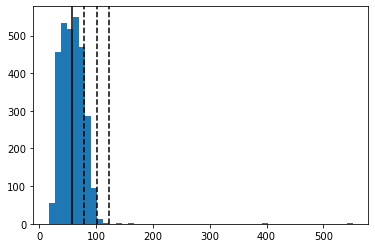

In [56]:
lengths = []
for system in df.Sistema.tolist():
    lengths.append(len(system))
m = statistics.median(lengths)
sd = np.std(lengths)

band_1 = m + sd
band_2 = band_1 + sd
band_3 = band_2 + sd


print("Media: " + str(m))
print("Desviación Estándar: " + str(sd))
print("Primera banda (34%): " + str(band_1))
print("Segunda banda (14%): " + str(band_2))
print("Tercera banda (2%): " + str(band_3))



plt.hist(lengths,bins=50)
plt.axvline(m,color='k')
plt.axvline(band_1,color='k', linestyle='dashed')
plt.axvline(band_2,color='k', linestyle='dashed')
plt.axvline(band_3,color='k', linestyle='dashed')


max_length = int(band_3)
print("Longitud máxima: " + str(max_length))
plt.show()

In [58]:
model_limit = []
for model in df.Sistema.tolist():
    model_limit.append(model[0:max_length])
padded,vocab = string2sequence(model_limit, max_length)

x = np.asarray(padded)
y = np.array(df.Likes.to_list())
x.shape,y.shape

Tamaño del vocabulario: 64
Índice: 
{'w': 1, '5': 2, '}': 3, '6': 4, 'I': 5, 'x': 6, '9': 7, 'K': 8, 'c': 9, ' ': 10, '8': 11, 'b': 12, 'R': 13, "'": 14, 'T': 15, 'Q': 16, 'X': 17, '{': 18, '0': 19, 'u': 20, 'k': 21, 'M': 22, 'h': 23, 'C': 24, '7': 25, ']': 26, 'P': 27, 'a': 28, 'd': 29, 'E': 30, 'Y': 31, 'V': 32, '[': 33, '1': 34, 'y': 35, '2': 36, 'O': 37, 'F': 38, '+': 39, '3': 40, 'Z': 41, 'e': 42, ',': 43, 'L': 44, 'D': 45, 't': 46, 'o': 47, 'v': 48, 'U': 49, 'q': 50, 'N': 51, 'J': 52, 'n': 53, ':': 54, '4': 55, 'W': 56, '-': 57, 'S': 58, 'A': 59, 'B': 60, 'f': 61, '.': 62, 'G': 63, 'H': 64}
Tamaño máximo de las secuencias: 122


((2984, 122), (2984,))

In [35]:
X_train, X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.20, random_state=42)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape


((2387, 122), (597, 122), (2387,), (597,))

## Modelo 4 - CNN

In [44]:
vocab_size = vocab+1
embedding_dimension = 32

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, embedding_dimension, input_length=max_length)(input_layer)
conv_layer_1 = Conv1D(filters=32, kernel_size=3, activation=tf.keras.layers.LeakyReLU())(embedding_layer)
pool_1 = MaxPooling1D(pool_size=2)(conv_layer_1)
conv_layer_2 = Conv1D(filters=32, kernel_size=3, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.01))(pool_1)
pool_2 = MaxPooling1D(pool_size=2)(conv_layer_2)
flatten = Flatten()(pool_2)
dense_2 = Dense(32, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer=l2(l2=0.01))(flatten)
dropout = Dropout(0.5)(dense_2)
output_layer = Dense(1, activation='sigmoid')(dropout)

model_4_cnn = Model(inputs=input_layer,outputs=output_layer)
model_4_cnn.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 122)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 122, 32)           2080      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 120, 32)           3104      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 60, 32)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 58, 32)            3104      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 29, 32)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 928)               0   

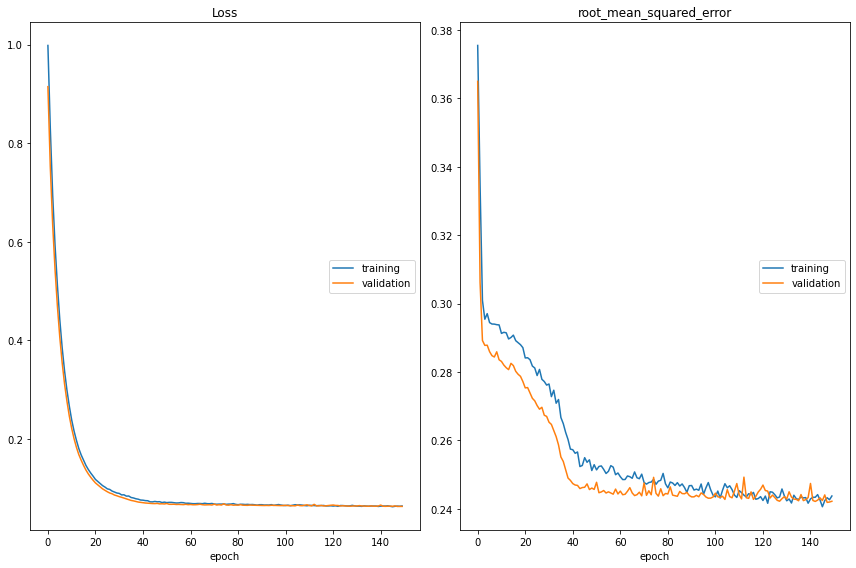

Loss
	training         	 (min:    0.063, max:    0.998, cur:    0.064)
	validation       	 (min:    0.063, max:    0.915, cur:    0.063)
root_mean_squared_error
	training         	 (min:    0.241, max:    0.375, cur:    0.244)
	validation       	 (min:    0.242, max:    0.365, cur:    0.242)


In [45]:
model_4_cnn.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_4_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=150, batch_size=32, verbose=1,callbacks=[PlotLossesKeras()])
model_4_cnn.save('model_4.h5')

## Modelo 5 - RNN

In [582]:
vocab_size = vocab+1
embedding_dimension = 32

input_layer = Input(shape=(max_length,)) 
embedding_layer = Embedding(vocab_size,embedding_dimension,input_length=max_length)(input_layer)
lstm_layer = LSTM(64)(embedding_layer)
dense1 = Dense(32,activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.01))(lstm_layer)
dense1 = Dropout(0.5)(dense1)
output = Dense(1, activation='sigmoid')(dense1)

model_5_rnn = Model(input_layer,output)
model_5_rnn.summary()


Model: "model_242"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_419 (InputLayer)       [(None, 122)]             0         
_________________________________________________________________
embedding_418 (Embedding)    (None, 122, 32)           2080      
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_734 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_465 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_735 (Dense)            (None, 1)                 33        
Total params: 29,025
Trainable params: 29,025
Non-trainable params: 0
_____________________________________________________

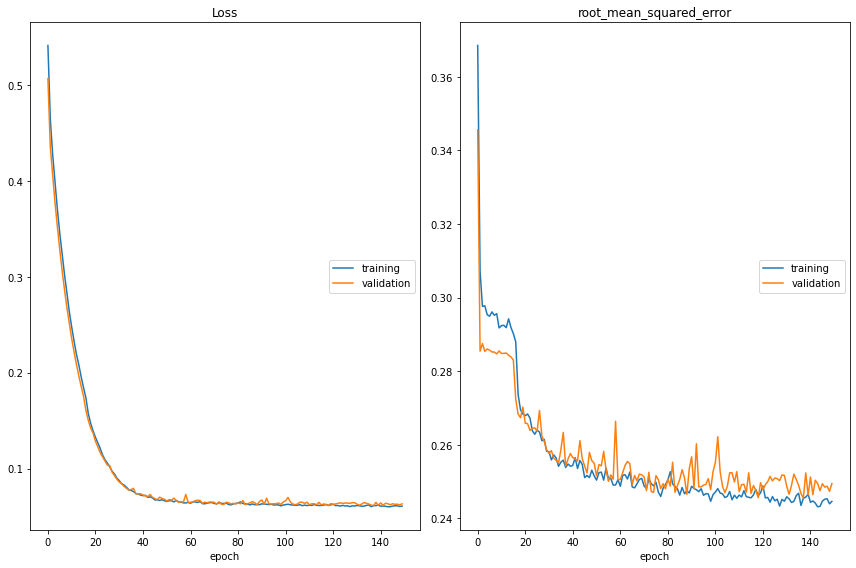

Loss
	training         	 (min:    0.060, max:    0.541, cur:    0.061)
	validation       	 (min:    0.061, max:    0.507, cur:    0.063)
root_mean_squared_error
	training         	 (min:    0.243, max:    0.369, cur:    0.245)
	validation       	 (min:    0.245, max:    0.346, cur:    0.249)


In [583]:
model_5_rnn.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_5_rnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=150, batch_size=32, verbose=1,callbacks=[PlotLossesKeras()])
model_5_rnn.save('model_5.h5')

## Modelo 6 - MultiChannel

In [20]:
vocab_size = vocab+1
embedding_dimension = 32
# channel 1
inputs1 = Input(shape=(max_length,))
embedding1 = Embedding(vocab_size,embedding_dimension,input_length=max_length)(inputs1)
conv1 = Conv1D(filters=32, kernel_size=4, padding='same', activation=tf.keras.layers.LeakyReLU())(embedding1)
pool_1 = MaxPooling1D()(conv1)
conv2 = Conv1D(filters=32, kernel_size=4, padding='same', activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.01))(pool_1)
pool_2 = MaxPooling1D(pool_size=2)(conv2)
flat1 = Flatten()(pool_2)

# channel 2
inputs2 = Input(shape=(max_length,))
embedding2 = Embedding(vocab_size, embedding_dimension, input_length=max_length)(inputs2)
conv3 = Conv1D(filters=32, kernel_size=6, padding='same', activation=tf.keras.layers.LeakyReLU())(embedding2)
pool_3 = MaxPooling1D()(conv3)
conv4 = Conv1D(filters=32, kernel_size=6, padding='same', activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.01))(pool_3)
pool_4 = MaxPooling1D()(conv4)
flat2 = Flatten()(pool_4)

# channel 3
inputs3 = Input(shape=(max_length,))
embedding3 = Embedding(vocab_size, embedding_dimension, input_length=max_length)(inputs3)
conv5 = Conv1D(filters=32, kernel_size=8, padding='same', activation=tf.keras.layers.LeakyReLU())(embedding3)
pool_5 = MaxPooling1D()(conv5)
conv6 = Conv1D(filters=32, kernel_size=8, padding='same', activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.01))(pool_5)
pool_6 = MaxPooling1D()(conv6)
flat3 = Flatten()(pool_6)

# merge
merged = concatenate([flat1, flat2, flat3])

dense1 = Dense(32, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=l2(l2=0.01))(merged)
dropout = Dropout(0.5)(dense1)
outputs = Dense(1, activation='sigmoid')(dropout)

model_6_multi_channel = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
model_6_multi_channel.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 122)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 122)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 122)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 122, 32)      2080        input_5[0][0]                    
____________________________________________________________________________________________

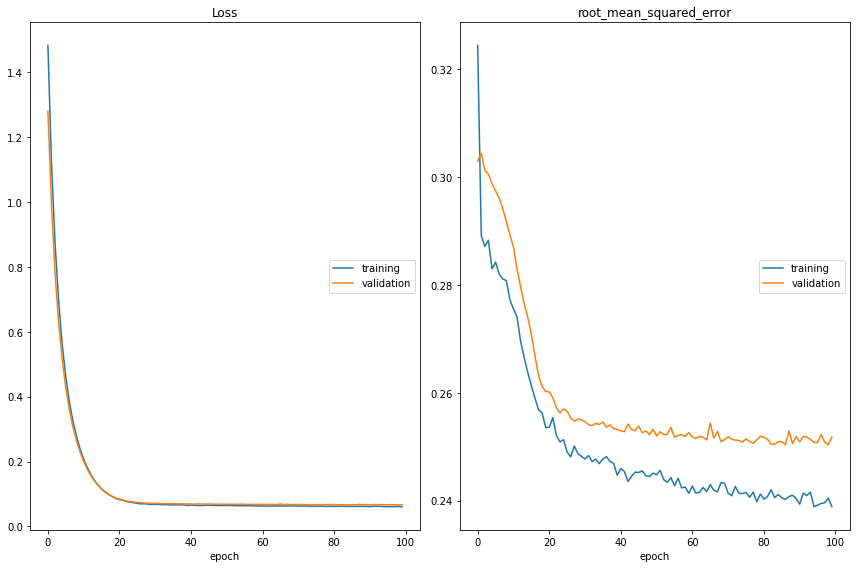

Loss
	training         	 (min:    0.061, max:    1.483, cur:    0.061)
	validation       	 (min:    0.066, max:    1.280, cur:    0.067)
root_mean_squared_error
	training         	 (min:    0.239, max:    0.324, cur:    0.239)
	validation       	 (min:    0.250, max:    0.304, cur:    0.252)


In [21]:
model_6_multi_channel.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_6_multi_channel.fit([X_train,X_train,X_train], Y_train, validation_data=([X_test,X_test,X_test], Y_test), epochs=100, batch_size=32, verbose=1,callbacks=[PlotLossesKeras()])
model_6_multi_channel.save('model_6.h5')

## Comparación de modelos


In [656]:
def get_mse_and_rmse(string_model, X, y):
    model = load_model(string_model)
    y_predict = model.predict(X)
    mse = mean_squared_error(y,y_predict, squared=True)
    rmse = math.sqrt(mse)
    return [mse,rmse]


models_result = dict()
y = np.array(df.Likes.to_list())


#Entrada para Baseline, modelo 1 y modelo 2
max_length = 5000
model_limit = []
for model in df.Desarrollado.tolist():
    model_limit.append(model[0:max_length])

padded,vocab = string2sequence(model_limit, max_length)
X = np.asarray(padded)
X_train, X_test,Y_train,Y_test = train_test_split(padded,y,test_size=0.20, random_state=42)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

#Baseline
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, Y_train)

y_predict = dummy_regr.predict(X)
mse = mean_squared_error(y, y_predict, squared=True)
rmse = math.sqrt(mse)
models_result['Baseline - Mean'] = [mse,rmse]

#Modelo 1 
string_model = 'model_1.h5'
models_result[string_model[0:7]] = get_mse_and_rmse(string_model, X, y)

#Modelo 2
string_model = 'model_2.h5'
models_result[string_model[0:7]] = get_mse_and_rmse(string_model, [X,X,X], y)

#Modelo 3
loaded_arr = np.loadtxt("autoencoder_outputs.txt")
x_read = loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] // 50, 50)
X = np.asarray(x_read)
string_model = 'model_3.h5'
models_result[string_model[0:7]] = get_mse_and_rmse(string_model,X,y)

#Entrada para modelo 4, modelo 5 y modelo 6
max_length = 122
model_limit = []
for model in df.Sistema.tolist():
    model_limit.append(model[0:max_length])
padded,vocab = string2sequence(model_limit, max_length)
X = np.asarray(padded)

#Modelo 4
string_model = 'model_4.h5'
models_result[string_model[0:7]] = get_mse_and_rmse(string_model,X,y)

#Modelo 5
string_model = 'model_5.h5'
models_result[string_model[0:7]] = get_mse_and_rmse(string_model,X,y)

#Modelo 6
string_model = 'model_6.h5'
models_result[string_model[0:7]] = get_mse_and_rmse(string_model,[X,X,X],y)

Tamaño del vocabulario: 48
Índice: 
{'M': 1, 'u': 2, 'N': 3, 'a': 4, 'b': 5, 'y': 6, 'm': 7, 'Z': 8, 't': 9, 'n': 10, '+': 11, 'k': 12, 'e': 13, 'C': 14, 'U': 15, 'F': 16, 'v': 17, 'E': 18, 'O': 19, 'q': 20, '[': 21, 'H': 22, 'A': 23, 'o': 24, ']': 25, 'I': 26, 'S': 27, 'P': 28, 'W': 29, 'V': 30, 'K': 31, 'B': 32, 'G': 33, 'T': 34, 'L': 35, 'w': 36, 'R': 37, 'p': 38, 'J': 39, 'D': 40, 'f': 41, 'Q': 42, 's': 43, 'j': 44, 'X': 45, '-': 46, 'Y': 47, 'h': 48}
Tamaño máximo de las secuencias: 5000
Tamaño del vocabulario: 64
Índice: 
{'M': 1, 'u': 2, 'N': 3, 'a': 4, 'b': 5, '8': 6, '9': 7, 'y': 8, 'c': 9, '7': 10, 'Z': 11, 't': 12, 'n': 13, '+': 14, '1': 15, 'k': 16, 'd': 17, 'e': 18, 'C': 19, '}': 20, 'U': 21, 'x': 22, 'F': 23, 'v': 24, 'E': 25, 'O': 26, 'q': 27, '[': 28, 'H': 29, 'A': 30, 'o': 31, '{': 32, ']': 33, 'I': 34, 'S': 35, 'P': 36, 'W': 37, 'V': 38, 'K': 39, 'B': 40, 'G': 41, 'T': 42, 'L': 43, 'w': 44, '.': 45, 'R': 46, '6': 47, ',': 48, '3': 49, 'J': 50, ':': 51, '0': 52, '5': 5

In [657]:
results_dataframe = pd.DataFrame.from_dict(models_result)
results_dataframe

,Baseline - Mean,model_1,model_2,model_3,model_4,model_5,model_6
0,0.082831,0.05381,0.053065,0.058139,0.055768,0.058615,0.056173
1,0.287804,0.23197,0.230358,0.241120,0.236153,0.242104,0.237008


## Partes donde los modelos fallan con más frecuencia (Histograma de errores)

In [ ]:
bins = [p/10 for p in range(0, 11)]
y = np.array(df.Likes.to_list())
for value in bins:
    definiciones_sistema_L = []
    sistema_desarrollado = []
    for index, row in df.iterrows():
        
        if row['Likes'] =
#Entrada para Baseline, modelo 1 y modelo 2
max_length = 5000
model_limit = []
for model in df.Desarrollado.tolist():
    model_limit.append(model[0:max_length])